# Predicción de la turbidez del agua
## Proyecto final - Introducción a la Inteligencia Artificial (2021-2S) 

Universidad Nacional de Colombia

Integrantes:



1.   Acevedo Rodriguez, Juan 
2.   Ahumada Lozano, Santiago
4.   Babativa Gomez, Edgar



#  Librerías , funciones y acceso a datos


### Librerías necesarias

In [ ]:

import numpy as np
import cv2 as cv 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from google.colab import drive

from google.colab.patches import cv2_imshow
from itertools import product 

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix





### Funciones de uso recurrente

In [ ]:
### Funciones de uso recurrente ### 

# Dado un valor de un diccionario retorna la llave.
def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

# Diccionarios para guardar los puntajes o métricas de cada modelo.
accuracies = {}
f1_scores = {}

###Acceso a datos mediante drive - mi unidad






In [ ]:
drive.mount('/content/drive')

# Ruta hacia la carpeta principal (DBturbidity). Este será nuestro directorio actual.

'''IMPORTANTE: Señor usuario si desea ejecutar las celdas de código,
 por favor escriba a continuación el directorio en drive -> mi unidad en donde se encuentra la carpeta de DBturbidity
 se recomienda leer todo el notebook sin ejecutar antes de hacer cualquier cambio'''

###
alternative_dir = 'reemplace esta cadena por la ruta a la carpeta DBturbidity'
###


default_dir = 'drive/MyDrive/clasificacion_IA/DBturbidity.zip (Unzipped Files)/DBturbidity'

try:
  os.listdir(alternative_dir)
  dir=alternative_dir
except:
  dir=default_dir

print(dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive/MyDrive/clasificacion_IA/DBturbidity.zip (Unzipped Files)/DBturbidity


# Preprocesamiento del conjunto de datos


### Dimensiones de las imágenes


Se pretende uniformizar las dimensiones de las imágenes, de tal forma que todas presenten el mismo tamaño $m\times n$ pixeles. En esta sección elegiremos los valores de $m$ y $n$ teniendo en cuenta ciertas consideraciones.

In [ ]:
# Lista para guardar los tamaños o dimensiones de todas las imágenes
shapes = []

# En este ciclo for anidado se leen todas las imágenes de cada subcarpeta y se guarda su tamaño en la lista 

# Primer for: recorrer todas las carpetas de DbTurbidity con ayuda de la librería os
for folder in os.listdir(dir):
  # La función join concatena cadenas de texto con un '/' entre ellas. Así podemos tener acceso a cada subcarpeta
  subfolder = os.path.join(dir,folder)
  # Segundo for: recorre todos los archivos dentro de una carpeta
  for file in os.listdir(subfolder):
    # Cargar una imagen
    img= cv.imread(os.path.join(dir,folder,file))
    # Guardar tamaño de la imagen
    shapes.append(img.shape)

In [ ]:
# Formar un conjunto o lista única con todos los tamaños encontrados
shapes_set = set(shapes)
print('Distintos tamaños de las imágenes:', shapes_set)

Distintos tamaños de las imágenes: {(1080, 1920, 3), (480, 720, 3), (3120, 4160, 3)}


Observamos que se tienen imágenes con 3 tamaños distintos

In [ ]:
# Relación de aspecto de las imágenes
for i,x in enumerate(shapes_set):
  print(f'Tamaño {i+1}: {x}')
  print(f'Razón entre alto y ancho: {x[0]/x[1]} \n')

Tamaño 1: (1080, 1920, 3)
Razón entre alto y ancho: 0.5625 

Tamaño 2: (480, 720, 3)
Razón entre alto y ancho: 0.6666666666666666 

Tamaño 3: (3120, 4160, 3)
Razón entre alto y ancho: 0.75 



Notamos que el tamaño de las imágenes no es proporcional (los rectángulos no son semejantes), de manera que, si se quiere que todas tengan la misma dimensión, es inevitable que algunas pierdan la relación de aspecto (se van a deformar). 

Consideramos la opción que brinda una razón intermedia entre alto y ancho (0.6666), por tanto, se elige el tamaño 480 x 720. Posteriormente se aplicará reducción a 10%, de manera que cada imagen quedará de dimensiones 48 x 72 pixeles.

### Preprocesamiento de imágenes y estructuración train-validation-test

####Sobre la partición del conjunto de datos

Una decisión importante a la hora de implementar modelos de aprendizaje para clasificación sobre un conjunto de datos, es cómo se va a particionar este en training, testing y validation. En general con nuestro grupo concordamos en la importancia de dejar una amplia fracción del conjunto de datos destinada a entrenar el modelo y el restante a evaluación y validación. En general hemos encontrado en la literatura cantidades como 70% de para entrenamiento.

Sin embargo nos topamos con que la división del conjunto de datos no sigue este común denominador. En efecto la división dada por la base de datos es relativamente mas "equitativa" para las 3 clases. Así que en lugar de reajustar estas proporciones, hemos optado por respetar esta distribución e implementar cada uno de los modelos de aprendizaje sobre este.

####Limpiando el conjunto de datos

Por otro lado, hemos hechado un vistazo a las imagenes dadas en la base de datos y nos encontramos con 3 características de este:


1.   Las imágenes presentan diversas gamas de colores y tonalidades.
2.   Las imágenes no tienen el mismo tamaño.
3.   Gran parte de las imágenes se encuentran "desviadas" del foco de la cámara.

Para el primer aspecto. Hemos aplicado un filtro sobre todas y cada una de las imágenes de tal manera que estas terminaran viéndose en escala de grises.

Por otro lado. En el problema del tamaño. Hemos aplicado una reducción del 5% a las imágenes de mayor tamaño y reajustado el tamaño de las medianas y pequeñas al tamaño resultante de reducir las pequeñas. Como observación, nos dimos cuenta que las imágenes reajustadas preservaban proporciones.

Por último, hemos considerado no muy relevante la presencia de "desviaciones" en las fotos pues esto es algo normal en los modelos de aprendizaje y se conocen como *outliers*. Así que encontrar fallas en las predicciones del modelo para estas fotos no les impide **generalizar**.

In [ ]:

# Se determina la codificación de las clases.
encode_label = {'Square':0,'SecchiDisk':1,'Secchi3000':2}
# Se define la dimensión (ancho,alto) que tendrán todas las imágenes
dim = (72,48)



# Se crea un diccionario cuyas llaves son los tres conjuntos de datos, 
# los valores son listas de duplas, 
# las duplas están en forma de lista [imagen,clase]
images = {'train':[],'validation':[],'test':[]}


# Ruta de la carpeta principal, este es nuestro directorio.
dir = 'drive/MyDrive/clasificacion_IA/DBturbidity.zip (Unzipped Files)/DBturbidity'


# Iteración anidada sobre cada carpeta y cada archivo en una carpeta
# 'listdir' crea una lista con los nombres de todos las carpetas en el directorio
for folder in os.listdir(dir): 

  # Separamos en una lista cada parte del nombre de la carpeta, usando como delimitador el guión bajo.
  splited_folder = folder.split('_')
  
  # La primera parte del nombre de la carpeta corresponde a la clase de figura
  label = splited_folder[0]
  # Codificamos la clase de la figura.
  label = encode_label[label]
  
  # La parte final del nombre corresponde al propósito o conjunto de datos al que pertenece la imagen; train,test o validation.
  purpose = splited_folder[-1]
  
  # iteración sobre los archivos de cada subcarpeta
  # path.join concatena cadenas de texto agregando un símbolo '/' entre ellas, de esta manera determinamos la ruta de cada subcarpeta
  subfolder = os.path.join(dir,folder)
  for file in os.listdir(subfolder):

    # cargar imagen
    img= cv.imread(os.path.join(dir,folder,file))
    # transformar a escala de grises
    img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # reducir tamaño
    img = cv.resize(img, dim, interpolation = cv.INTER_AREA)

    # guardar imagen como array junto con su clase en el conjunto de datos al que pertenece
    images[purpose].append([img,label])

In [ ]:
for key,value in images.items():
  print(f'Cantidad de imágenes para {key}: \t {len(value)}')

print('\nDimensiones de cada imagen: \t',images['train'][0][0].shape)

Cantidad de imágenes para train: 	 252
Cantidad de imágenes para validation: 	 252
Cantidad de imágenes para test: 	 504

Dimensiones de cada imagen: 	 (48, 72)


### Conjuntos de input y output (X,y)

In [ ]:
X, y = {}, {}

print('Dimensiones de los arreglos: \n')
for data_set in images:
  X[data_set] = []
  y[data_set] = []
  for couple in images[data_set]:
    img = couple[0]
    label = couple[1]
    X[data_set].append(img)
    y[data_set].append(label)
  X[data_set] = np.array(X[data_set])
  y[data_set] = np.array(y[data_set])
  print(f'X[{data_set}]:{X[data_set].shape}\ny[{data_set}]:{y[data_set].shape} \n')


Dimensiones de los arreglos: 

X[train]:(252, 48, 72)
y[train]:(252,) 

X[validation]:(252, 48, 72)
y[validation]:(252,) 

X[test]:(504, 48, 72)
y[test]:(504,) 



In [ ]:
amount = [ [ list(y[d_set]).count(i)  for i in range (3)]for d_set in images.keys()]
print(amount)

[[84, 84, 84], [84, 84, 84], [168, 168, 168]]


Observamos que hay la misma cantidad de imágenes de cada categoría en todos los conjuntos de datos. Esto facilita la evaluación de los modelos como veremos más adelante 

# Entrenamiento y evaluación de modelos

## Evaluación de los modelos (Métricas)

Explicación de las métricas que vamos a usar y la matriz de confusión

Matriz de Confusión

Una matriz de confusión es una matriz que permite mostrar del número de predicciones correctas e incorrectas realizadas por un modelo de clasificación y sus metricas permiten medir el rendimiento de un modelo de clasificación.

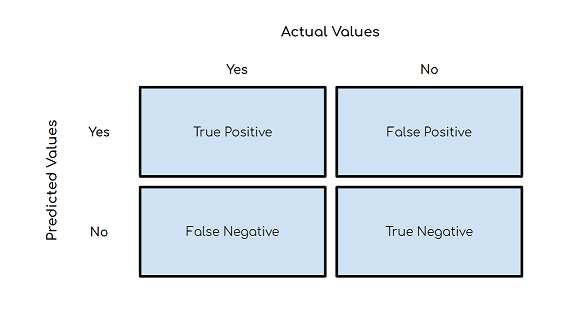

CONDITION POSITIVE (P) : Número de casos reales positivos en los datos.

CONDITION NEGATIVE (N) : Número de casos reales negativos en los datos.

TRUE POSITIVE (TP): Resultado en el que el modelo predice correctamente la clase positiva.

TRUE NEGATIVE (TN): Resultado donde el modelo predice correctamente la clase negativa.

FALSE POSITIVE (FP): Resultado donde el modelo predice incorrectamente la clase positiva cuando en realidad es negativa.

FALSE NEGATIVE (FN): Resultado en el que el modelo predice incorrectamente la clase negativa cuando en realidad es positiva.

Métricas que se pueden obtener a partir de una matriz de confusión.

Exactitud ( Accuracy)	

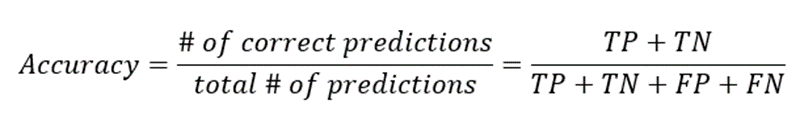
 
Precisión (Precision)

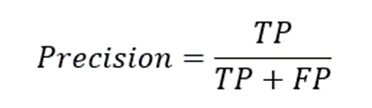

 
Sensibilidad ( Recall)

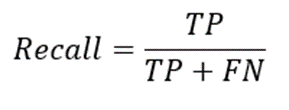


Puntuacíon F1( f1_score)

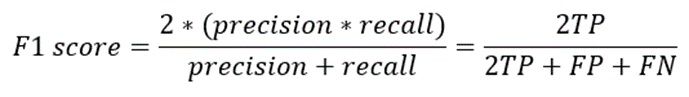
 

Support : número de elementos en cada clase ( datos reales).





## Support Vector Machine

Los algoritmos de Soporte Vectorial (SV) son comúnmente considerados los primeros spin-off practicables de la historia de la teoría del aprendizaje estadístico.Formalmente, una \textit{maquina de soporte vectorial (SVM)} construye un hiperplano o conjunto de hiperplanos sobre un espacio de mayor dimensión, o dimensión infinita, el cual puede ser usado para la clasificación, regresión, u otras tareas como la detección de valores atípicos.  Intuitivamente, una buena separación se logra por un hiperplano que tiene la mayor distancia con respecto a los puntos más cercanos de datos de entrenamiento de una clase (llamado margen funcional), ya que, en general, a mayor margen, menor error de generalización sobre el clasificador.



###Kernel en SVM
El clasificador de soporte vectorial descrito hasta ahora encuentra límites lineales en el espacio de los datos. Así como otros métodos lineales, podemos hacer el procedimiento más flexible a través de la ampliación del espacio de datos de entrada usando bases de expansión. Si tomamos $k(x,y)=\phi(x)\bullet\phi(y)$ como una *función kernel*, entonces podemos escribir nuestra maquina de soporte vectorial en términos de los kernels,

$$\hat{f}(x)=\mathop{sign}(\sum_{i=1}^l\alpha_i^*y_ik(x_i,x_j)-\sum_{i=1}^l\alpha_i^*y_i(x_i,\_{sv^+})+1)$$ 

Podemos escribir nuestro algoritmo de entrenamiento en términos de funciones del kernel también,$$\overline{\alpha^*}=\mathop{argmax}\left(\sum_{i=1}^l\alpha_i-\frac{1}{2}\sum_{i=1}^l\sum_{j=1}^ly_iy_j\alpha_i\alpha_jk(x_i,x_j)\right)$$
sujeto a las condiciones, $$\sum_{i=1}^ly_i\alpha_i=0,\hspace{2em}\alpha_i\geq0,\hspace{2em}i=1,\cdots,l$$La selección del núcleo adecuado para un problema de clasificación no lineal en particular se denomina **búsqueda de características**. *(Extraído de Referencia 6)*

### Implementando SVM en la base de imágenes (Teoría y precisiones)

Sobre la dimensión de las imágenes. 





Al momento de implementar el modelo del *Support vector machine* en una base de datos compuesta por arreglos 2-dimensionales, es decir, matrices, los cuales representan numéricamente las imágenes. Una preocupación natural que nace es el hecho de que el *SVM* trabajan con arreglos 1-dimensionales (Vectores). 

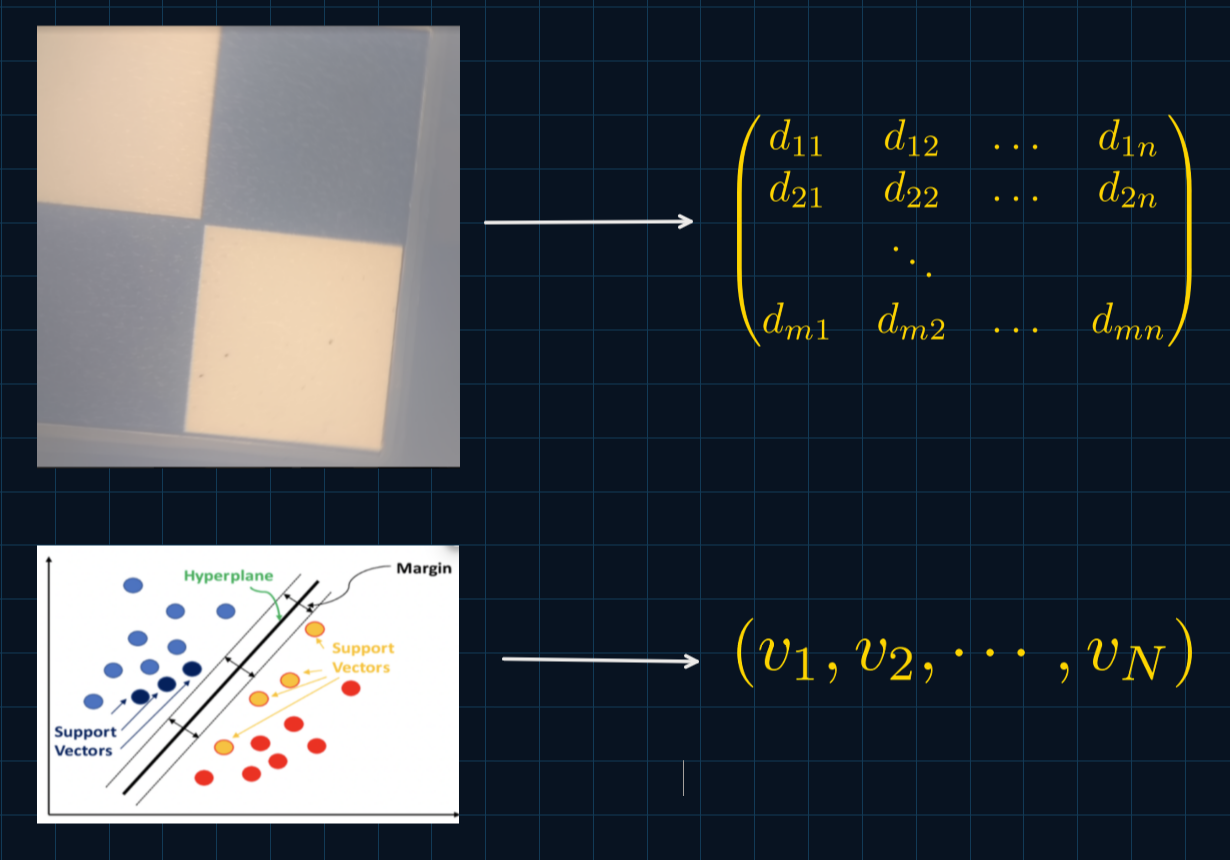

Donde podemos en general asociar a cada imagen de $n×m$ pixeles un vector de tamaño $n×m$. Lo dicho lo hemos realizado definiendo el nuevo vector como la *concatenación* de los vectores filas contenidos en cada matriz.

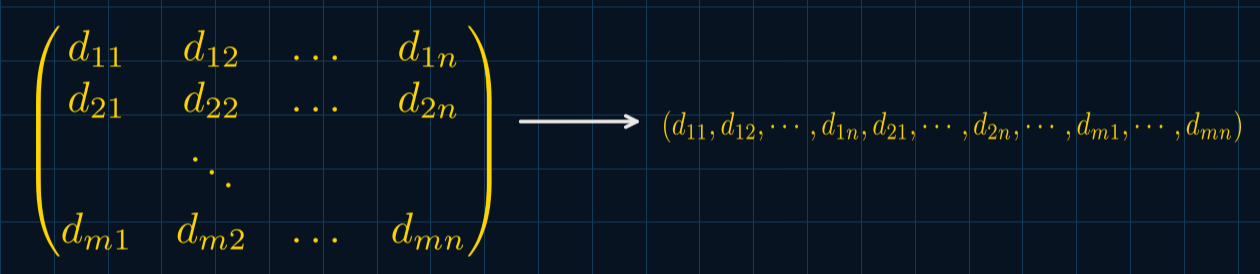

Con lo cual se consigue aplicar *SVM* a esta base de datos. 

Evidentemente la función objetivo a la que se desea aproximar mediante el presente modelo tiende a hacer un hiperplano que "habita" en una $\mathbb{R}$ dimesión de tamaño $n\times m$ así que en general presentar una representación completa de la clasificación que se genera es limitada. Así que se puede optar por visualizar los resultados de clasificación considerando 2 dimesiones (o características) al tiempo. 

*SVM* al no soportar la clasificación entre más de dos clases, entonces se utilizará el mismo principio de clasificación binaria múltiples veces, para esto podemos tener varios enfoques donde se nos presentan el *one-to-one* donde el problema multiclase se convierte en un problema entre dos clases en este caso para cada par de clases y donde  podemos usar $(m(m-1))/2 $ *SVN’s* y el otro enfoque es el *one-to-rest* donde igual que al anterior, el problema se convierte en un problema de dos clases donde el clasificador es independiente para cada clase teniendo $m$ *SVN’s* \\
Vamos a tomar como ejemplo un problema de clasificacion de 3 clases,como referencia la imagen: \\
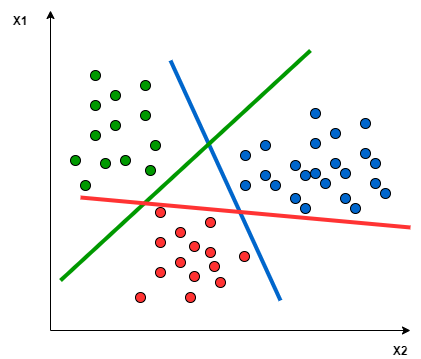 \\
En *one-to-one* necesitamos un hiperplano para separar cada dos clases, pero despreciando los puntos de cualquier clase separada como se muestra en el ejemplo que dependiendo la separación no se tendrán en cuenta unos u otros puntos:
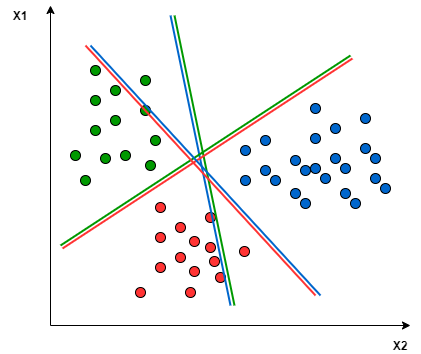

En *one-to-rest* necesitamos un hiperplano para separar una clase de todas las otras clases, dividiendo así en dos grupos uno para los puntos de dicha clase y otro para todos los demás puntos: \\
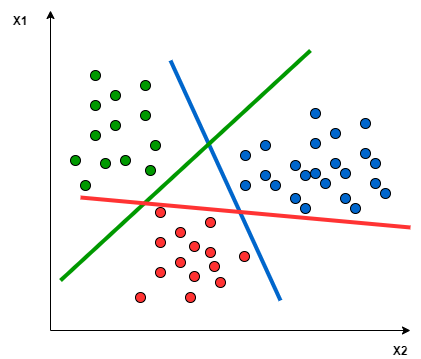


### Implementación (Código)

Como hemos visto, el algoritmo SVM no admite como muestras de input  $X$ arreglos de más de dos dimensiones, por tal razón es necesario transformar cada imagen de un arreglo 2-dimensional a uno de una sola dimensión. 


In [ ]:
# En el diccionario flatten_X se guardan los conjuntos, divididos en train,validation y test, de imágenes "aplanadas", 
# Se realiza este procedimiento mediante el método reshape.

flatten_X = {} 
for d_set in images:
  flatten_X[d_set] = X[d_set].reshape(( X[d_set].shape[0] , X[d_set].shape[1]*X[d_set].shape[2]))
  # Reescalamiento de valores de [0,255] a [0,1]
  flatten_X[d_set] = flatten_X[d_set]/255
  print(f'flatten_X[{d_set}]:{flatten_X[d_set].shape}\ny[{data_set}]:{y[data_set].shape} \n')

flatten_X[train]:(252, 3456)
y[test]:(504,) 

flatten_X[validation]:(252, 3456)
y[test]:(504,) 

flatten_X[test]:(504, 3456)
y[test]:(504,) 



In [ ]:
# Entrenamiento y definición de los modelos
from sklearn import svm

# Se probarán cuatro modelos, resultado de las posibles combinaciones entre kernels y funciones de decisión en las siguientes listas 
kernels = ['rbf','poly']
decision_fn = ['ovo','ovr']

SVM = {}
for ker,dec in product(kernels,decision_fn):
  SVM[ker+'_'+dec] = svm.SVC(  kernel=ker  ,  decision_function_shape=dec  ) # Definición del modelo
  SVM[ker+'_'+dec].fit( flatten_X['train'] , y['train'] ) # Entrenamiento del modelo

In [ ]:
# Calibración de hiperparámetros: Función de decisión y kernel.
# Usamos el conjunto de validación

acc_scores, f_1_scores = [],[]
for model in SVM.keys():
  prediction = SVM[model].predict(flatten_X['validation'])
  acc_scores.append(accuracy_score(y['validation'], prediction))
  f_1_scores.append(f1_score(y['validation'], prediction, average='weighted'))

pd.DataFrame({'Combinación':list(SVM.keys()), 'Precisión':acc_scores, 'Puntaje f1':f_1_scores})

,Combinación,Precisión,Puntaje f1
0,rbf_ovo,1.000000,1.000000
1,rbf_ovr,1.000000,1.000000
2,poly_ovo,0.996032,0.996032
3,poly_ovr,0.996032,0.996032


Observamos que el hiperparámetro con mayor incidencia es el kernel. Se obtienen los mejores resultados usando el kernel RBF indistintamente de la función de decisión. Elegiremos el modelo **SVM con kernerl RBF y función de decisión one vs one (ovo)**

In [ ]:
# Prueba del modelo. 
# Usamos el conjunto de testeo

# Predicción
svm_test_pred = SVM['rbf_ovo'].predict(flatten_X['test'])
# Cálculo de exactitud
accuracies['SVM'] = accuracy_score(y['test'], svm_test_pred)
# Cálculo de puntaje f1
f1_scores['SVM'] = f1_score(y['test'], svm_test_pred, average='weighted')

# Se muestran los resultados
print('Precisión sobre todo el conjunto de testeo: {:.2f} \nPuntaje f1 sobre todo el conjunto de testeo: {:.2f}'.format(accuracies['SVM'],f1_scores['SVM']))

Precisión sobre todo el conjunto de testeo: 0.67 
Puntaje f1 sobre todo el conjunto de testeo: 0.68


Observamos que el modelo e hiperparámetros elegidos de SVM brindan una exactitud del $67\%$ sobre el conjunto de prueba (testeo), además un puntaje $f_1$ de $0.68$. 


## Random Forest 

Siendo el random forest es un algoritmo de aprendizaje supervisado, donde el random forest crea múltiples árboles de decisión y los fusiona para obtener una predicción más precisa y estable, veamos cómo se vería un bosque aleatorio: 

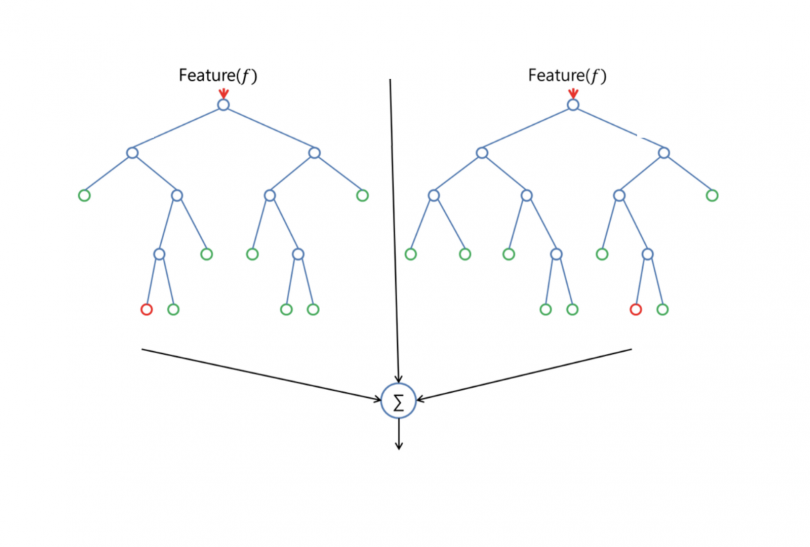

Random forest agrega aleatoriedad al modelo, mientras crecen los árboles. En lugar de buscar la característica más importante al dividir un nodo, busca la mejor característica entre un subconjunto aleatorio de características. Esto da como resultado una amplia diversidad que generalmente da como resultado un mejor modelo.

Cada árbol es construido usando el siguiente algoritmo:
1.	Sea N el número de casos de prueba, M es el número de variables en el clasificador.
2.	Sea m el número de variables de entrada a ser usado para determinar la decisión en un nodo dado; m debe ser mucho menor que M
3.	Elegir un conjunto de entrenamiento para este árbol y usar el resto de los casos de prueba para estimar el error.
4.	Para cada nodo del árbol, elegir aleatoriamente m variables en las cuales basar la decisión. Calcular la mejor partición del conjunto de entrenamiento a partir de las m variables.

Acá va la explicación teórica del modelo

### RF Implementación 




Al igual que el SVM, el random forest solo admite muestras de una dimensión, por tanto, es necesario usar los arreglos de la imágenes "aplanadas". Así, los datos de interés para conjuntos de input (X) están guardados en el diccionario `flatten_X`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Definición y entrenamiento
RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
RF.fit(flatten_X['train'], y['train'])

# Verificamos si es necesario calibrar algún hiperparámetro teniendo en cuenta el conjunto de validación 
RF_val_pred = RF.predict(flatten_X['validation'])
RF_val_acc = accuracy_score(y['validation'], RF_val_pred)
RF_val_f1 = f1_score(y['validation'], RF_val_pred, average='weighted' )

print('Exactitud en la validación: {} \nPuntaje f1 en la validación: {}'.format(RF_val_acc, RF_val_f1))

Exactitud en la validación: 1.0 
Puntaje f1 en la validación: 1.0


Observamos que no es necesario calibrar ningún hiperparámetro, pues se obtiene precisión perfecta en el conjunto de validación. Procedemos a probar el modelo considerando el conjunto de testeo. 

In [ ]:
RF_test_pred = RF.predict(flatten_X['test'])
accuracies['RF'] = accuracy_score(y['test'], RF_test_pred)
f1_scores['RF'] = f1_score(y['test'], RF_test_pred, average='weighted' )

print('Precisión sobre todo el conjunto de testeo: {:.2f} \nPuntaje f1 sobre todo el conjunto de testeo: {:.2f}'.format(accuracies['RF'],f1_scores['RF']))

Precisión sobre todo el conjunto de testeo: 0.65 
Puntaje f1 sobre todo el conjunto de testeo: 0.63


**Nota**: Se probó definir el modelo con diferente número de estimadores, a saber 10,100,1000 se obtuvo un mejor resultado en el conjunto de *testeo* con 100 estimadores.

Por lo tanto, la exactitud del Random Forest es del $65\%$ y el puntaje $f_1$ es de 0.63

## KNN

### Explicación del modelo

(K-Nearest Neighbors) es un algoritmo el cual clasifica un nuevo dato en un grupo ya existente(etiquetado) a partir de los k vecinos mas cercanos al nuevo dato. Para ello,calcula las distancias euclidianas entre el nuevo dato y cada uno de los k-isemos elementos de los grupos etiquetados. Luego,ordena dichas distancias de menor a mayor para ir seleccionando el grupo a pertenecer.El grupo al que se asignará el nuevo dato será el de mayor frecuencia con menores distancias.

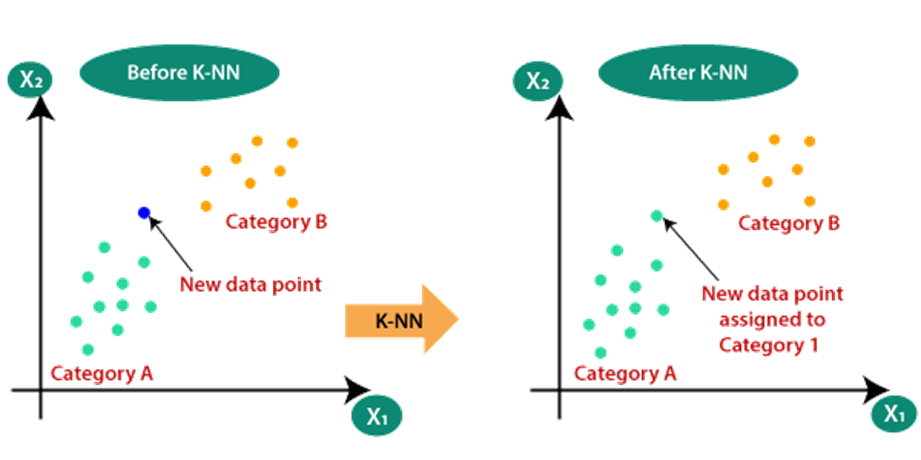

Pasos:

1-	Establecer el “k” vecinos.

2-	Calcular la distancia euclidiana de k número de vecinos.

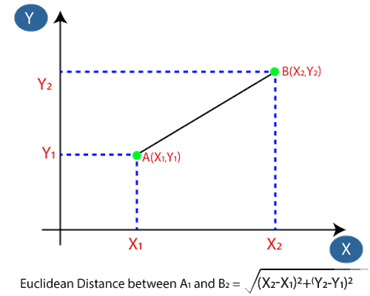

3-	Tomar los k vecinos más cercanos (a partir de la distancia euclidiana calculada) al dato a clasificar.

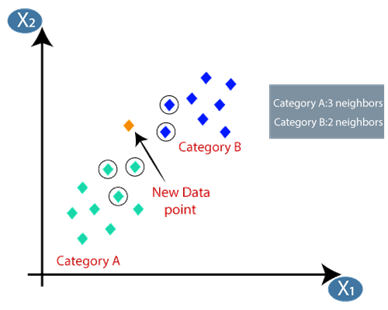

4-	Entre los k vecinos, contar el numero de puntos de cada categoría.

5-	Asignar el nuevo punto de datos a la categoría en el cual el numero de k vecinos es máximo





### Implementación (Código)

Al igual que en el caso de la SVM y el RF, el algoritmo KNN de scikit learn admite únicamente arreglos de una dimensión como muestras en el input $(X_i)$, así pues será necesario trabajar con imágenes "aplanadas", recodermos que éstas se encuentran en el diccionario `flatten_X`. Cabe resaltar que únicamente calibraremos el hiperparámetro $k$ usando el conjunto de validación. Para esto, entrenamos y evaluamos el modelo teniendo en cuenta diferentes valores de k en el rango $k\in(1,30)$

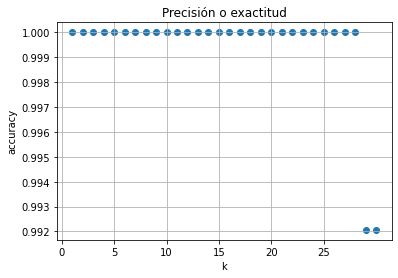

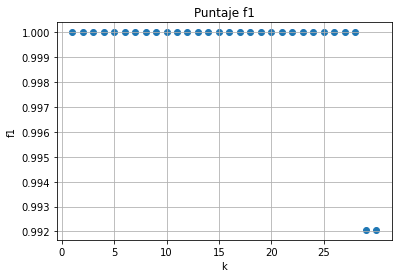

In [ ]:
# Entrenamiento y calibración de hiperparámetros: Valor de K.
from sklearn.neighbors import KNeighborsClassifier

#Listas para guardar el score de cada k
knn_acc, knn_f1 = [],[]
# Ciclo para entrenar y validar con los diferentes k
for k in range(1,31):
  # Definición del modelo
  knn = KNeighborsClassifier(n_neighbors=k)
  # Entrenamiento
  knn.fit(flatten_X['train'],y['train'])
  #Predicción 
  predicted_current_k =knn.predict(flatten_X['validation'])
  # Comparar y guardar métricas
  knn_acc.append(accuracy_score(y['validation'],predicted_current_k))
  knn_f1.append(f1_score(y['validation'], predicted_current_k, average='weighted' ))

# Visualizar métricas vs valores de k 

# precisión
plt.figure()
plt.title('Precisión o exactitud')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(range(1,31), knn_acc)
plt.grid(True)
plt.xticks(list(range(0,30,5)))
plt.show()

#puntaje f1
plt.figure()
plt.title('Puntaje f1')
plt.xlabel('k')
plt.ylabel('f1')
plt.scatter(range(1,31), knn_f1)
plt.grid(True)
plt.xticks(list(range(0,30,5)))
plt.show()

Vemos que se obtiene precisión y puntaje $f_1$ perfecto con $k\in(1,28)$. Elegiremos $k=10$ para la prueba del modelo. 

In [ ]:
# Prueba o testeo del modelo KNN

KNN_test_pred = RF.predict(flatten_X['test'])
accuracies['KNN'] = accuracy_score(y['test'], KNN_test_pred)
f1_scores['KNN'] = f1_score(y['test'], KNN_test_pred, average='weighted' )

print('Precisión sobre todo el conjunto de testeo: {:.2f} \nPuntaje f1 sobre todo el conjunto de testeo: {:.2f}'.format(accuracies['KNN'],f1_scores['KNN']))


Precisión sobre todo el conjunto de testeo: 0.65 
Puntaje f1 sobre todo el conjunto de testeo: 0.63


## Red Neuronal Convolucional

###Descripción general del CNN

Dada una rejilla o matriz $I$ (de imagen) cuyo tamaño sea $m×n$ podemos aplicar un filtro que destaque componentes de la imagen de cara a facilitar la clasificación (A manera de comentario; si en una serie de imágenes queremos identificar si se dibuja o no un número, nos interesa más la figura del trazo que destaca el simbolo *número*. Sin embargo no precisamos de información externa como *de qué color se hizo el trazo*, es por ello que nos interesa eliminar dicho ruido). La convolución de hecho es aplicada para este tipo de cosas y su nombre está estrechamente relacionada con la convolución usual que conocemos de asignaturas como EDO, Integración, análisis funcional, entre otros.

En escencia una convolución mide que tanto amontonamiento de una función se halla sobre la otra en un intervalo y se expresa usualmente con la integral

$$\int_0^tf(t)g(x-t)dx$$

Así que de forma análoga trabajan las CNN. Miden que tanto amontonamiento (O importancia) vamos a dar a ciertas características. La convolución se realiza entonces entre la rejilla y una matriz adicional conocida como *kernel* la cual ayudará a destacar trazos de una imagen que sean importantes y omitir los que no lo sean. En la siguiente sección hemos hecho un esfuerzo por dar nuestra interpretación del kernel y cómo se puede definir esta operación. Por el momento presentaremos en la siguiente imagen el resultado de aplicar convolución a una imagen en la que se quiere destacar las curvas más relevantes:


Imagen original: 


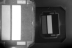


 
Imagen aplicando filtro para contorno: 


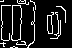

In [ ]:
# Ejemplo de detección de contornos # 

print('Imagen original: ')
original_img=X['validation'][0]
cv2_imshow(original_img)

print('\n \nImagen aplicando filtro para contorno: ')
contour = cv.Canny(original_img, threshold1=100, threshold2=200)
cv2_imshow(contour)

### Sobre el kernel de la convolución

Tras haber trabajado en la implementación del modelo de CNN en nuestra base de datos, naturamente nos hemos topado con un concepto clave a la hora de filtrar imagénes mediante la convolución, con esto nos referimos al **Kernel de la red neuronal convolucional**. Consignaremos a continuación lo que hemos encontrado.

La convolución dada tras realizar el filtrado de la imagen $I_{n×m}$, obteniendo una nueva imagen derivada $I'_{(n-1)×(m-1)}$. Se realiza mediante una matriz cuadrada K (De orden 3) conocida como Kernel, lo anterior lo podemos expresar mediante la ecuación

$$ I':= I*K$$

Y la operación $*$ se realiza de la siguiente manera:

$$I'_{ij}:=\sum_{k=i+1}^{i+4}\sum_{p=j+1}^{j+4} I_{kp}\cdot K_{(i+4-k)(j+4-p)} $$

Donde $i\in\{0,1,\dots, n-1\}, j\in\{0,1,\dots, m-1\}$

**Nota relevante:** Aparentemente la anterior regla de asignación del filtro parece demasiado enrevesada -Y de hecho lo es- ya que lo hemos planteado nostros (Posiblemente se encuentre en la literatura fórmulas mas simples). Sin embargo la pensamos teniendo en cuenta la esencia de este procemiento: Tomamos la matriz kernel 3x3 y la recorremos tantas veces como formas en que esta se puede ocupar en la matriz $I$ y realizamos una especie de producto punto entre el kernel $K$ y la submatriz de $I$ de orden 3x3 que en dado paso logremos emparejar con $K$.

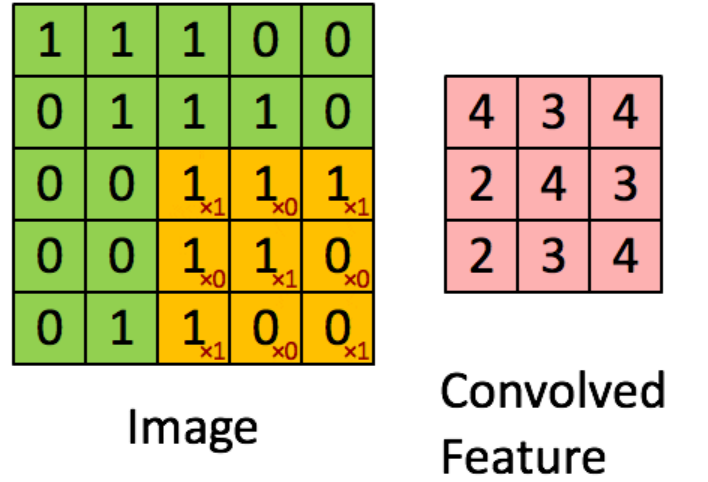

### Implementación CNN (código)

Una de las ventajas de la CNN es que admite muestras para input de 3 dimensiones o más, de manera que no es necesario "aplanar" las imágenes, por el contrario, es preciso que cada imágen tenga las siguientes dimensiones: 

$$(alto,ancho,color)$$


En caso de que las imágenes estuviesen a color, se tiene que $color=3$, debido a la construcción RGB. Sin embargo, en nuestro caso las imágenes están en escala de grises, por lo tanto, $color=1$. 

Teniendo en cuenta un arreglo que contemple varias muestras, las dimensiones de los conjuntos de input ($X$), serían las siguientes 

$$(\# \text{de muestras}, 48, 72, 1)$$

En el siguiente bloque de código realizamos este cambio de dimensión en los arreglos y los guardamos en el diccionario `re_dim_X`

In [ ]:
# Re-dimensión de los arreglos  (como vimos en el bloque de texto anterior)
# Re-escalamiento de valores, de escala [0,255] a escala [0,1]

print('Dimensiones de los nuevos arreglos \n')
re_dim_X = {}
for d_set in X:
  re_dim_X[d_set] = X[d_set].reshape((X[d_set].shape[0], 48, 72,1)) # Re-dimensión 
  re_dim_X[d_set] = re_dim_X[d_set]/255 # Re-escalamiento 
  print(f're_dim_X[{d_set}] \n {re_dim_X[d_set].shape} \n')

Dimensiones de los nuevos arreglos 

re_dim_X[train] 
 (252, 48, 72, 1) 

re_dim_X[validation] 
 (252, 48, 72, 1) 

re_dim_X[test] 
 (504, 48, 72, 1) 



In [ ]:
# Entrenamiento y calibración de epochs

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

model = Sequential()
# Capa convolucional
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(48,72,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# Capa de reducción de dimensión
model.add(Flatten())
# Capa de neuronas escondida 
model.add(Dense(100, activation='relu'))
# Capa de salida
model.add(Dense(10, activation='softmax'))
# Compilación de las capas
model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer='adam')

# Entrenamiento del modelo con 20 epochs
model.fit(re_dim_X['train'], y['train'], batch_size=128, epochs=20, validation_data=(re_dim_X['validation'], y['validation']))

Epoch 1/20
2/2 [==============================] - 1s 671ms/step - loss: 2.2443 - accuracy: 0.1548 - val_loss: 4.0607 - val_accuracy: 0.3333
Epoch 2/20
2/2 [==============================] - 1s 539ms/step - loss: 4.4767 - accuracy: 0.3571 - val_loss: 3.3806 - val_accuracy: 0.3968
Epoch 3/20
2/2 [==============================] - 1s 542ms/step - loss: 2.3107 - accuracy: 0.4365 - val_loss: 1.2337 - val_accuracy: 0.5437
Epoch 4/20
2/2 [==============================] - 1s 543ms/step - loss: 1.5782 - accuracy: 0.4881 - val_loss: 1.1076 - val_accuracy: 0.5952
Epoch 5/20
2/2 [==============================] - 1s 551ms/step - loss: 0.7590 - accuracy: 0.6270 - val_loss: 0.4064 - val_accuracy: 0.8730
Epoch 6/20
2/2 [==============================] - 1s 564ms/step - loss: 0.5424 - accuracy: 0.8135 - val_loss: 0.7680 - val_accuracy: 0.6984
Epoch 7/20
2/2 [==============================] - 1s 549ms/step - loss: 0.6755 - accuracy: 0.7143 - val_loss: 0.2916 - val_accuracy: 0.8611
Epoch 8/20
2/2 [====

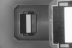

Dimensiones del arreglo antes de ser procesada por la CNN:  (1, 48, 72, 1)
Predicción:  SecchiDisk


In [ ]:
#### ¿Cómo predecir mediante la cnn la categoría de una imagen? ###
# El proceso es un poco diferente al de la SVM debido a la arquitectura de la red

# Imprimir la imagen
cv2_imshow(X['test'][0])

# Re-dimensionar correctamente la imagen de acuerdo al input_shape de la CNN
sample = np.array([re_dim_X['test'][0]])
print('Dimensiones del arreglo antes de ser procesada por la CNN: ',sample.shape)

# Predicción
img_pred = model.predict(sample) # El método predict retorna un vector
img_class_encoded = np.argmax(img_pred, axis=1) # La clase predicha corresponde al índice del elemento con mayor valor en el vector
img_class_decoded = get_key( img_class_encoded , encode_label) # Decodificamos la class ( número -> nombre )
print('Predicción: ',img_class_decoded)


In [ ]:
### Predicción sobre todo el conjunto de Testeo ###

cnn_pred_vectors = model.predict(re_dim_X['test']) # Vectores
cnn_pred=np.argmax(cnn_pred_vectors,axis=1) # Clases numéricas

accuracies['CNN'] = accuracy_score(y['test'], cnn_pred)
f1_scores['CNN'] = f1_score(y['test'], cnn_pred, average='weighted')
print('Precisión de la CNN sobre todo el conjunto de testeo: {:.2f} \nPuntaje f1 de la CNN sobre todo el conjunto de testeo: {:.2f}'.format(accuracies['CNN'],f1_scores['CNN']))

Precisión de la CNN sobre todo el conjunto de testeo: 0.60 
Puntaje f1 de la CNN sobre todo el conjunto de testeo: 0.61


# Modelo elegido

A continuación veremos un resumen de los puntajes o métricas de los modelos con respecto al conjunto de prueba o testeo, después de haber calibrado hiperparámetros teniendo en cuenta conjunto de validación.

In [ ]:
scores_summary = pd.DataFrame( {'Modelo':accuracies.keys(), 'Precisión':accuracies.values(), 'Puntaje f1':f1_scores.values()})
scores_summary.head(4)

,Modelo,Precisión,Puntaje f1
0,SVM,0.674603,0.676836
1,RF,0.646825,0.633562
2,KNN,0.646825,0.633562
3,CNN,0.599206,0.606423


Concluimos que el mejor modelo de acuerdo a ambas métricas es el SVM, recordemos que este modelo en nuestro se caracteriza por el Kernel RBF y función de decisión One vs One. De manera que este es el modelo elegido.

Ya canocemos el puntaje $f_1$ y la precisión o exactitud del modelo elegido, procedemos a graficar la matriz de confusión para comprender mediante este gráfico la precisión en cada clase.

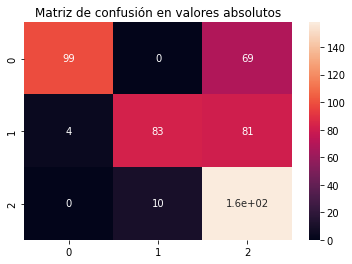

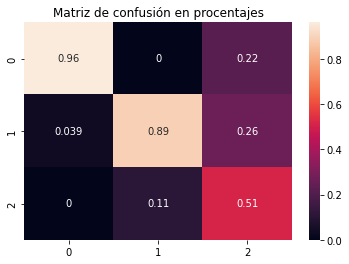

In [ ]:
# Se crea la matriz de  confusión con ayuda de la función importada de sci kit learn 
conf_matrix = confusion_matrix(y['test'], svm_test_pred)

# Se imprime la matriz
sns.heatmap(conf_matrix, annot=True)
plt.title('Matriz de confusión en valores absolutos')
plt.show()

# Se generan los valores en porcentajes
conf_matrix = conf_matrix/sum(conf_matrix) # Valores en porcentajes
# Se imprime la matriz con colores usando la librería Seaborn
sns.heatmap(conf_matrix, annot=True)
plt.title('Matriz de confusión en procentajes')
plt.show()

Concluimos que en nuestro modelo elegido el $Sechi3000$ es el que peor precisión tiene, mientras que $Square$ es bastante  reconocible, finalmente $SechiDisk$ tiene una precisión aceptable.

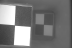

[0]	Predicción: Square 
 



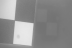

[0]	Predicción: Square 
 



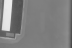

[2]	Predicción: Secchi3000 
 



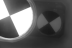

[1]	Predicción: SecchiDisk 
 



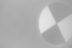

[2]	Predicción: Secchi3000 
 



In [ ]:
# Visualización de algunos ejemplos

random.seed(0)
shuffled_test = images['test'].copy()
random.shuffle(shuffled_test)

for i in range (5):
  sample = shuffled_test[i+100][0]
  cv2_imshow(sample) # Se muestra la imagen
  sample = sample/255
  single_prediction = SVM['rbf_ovo'].predict([np.array(sample).ravel()]) # Predicción de clase en número
  fig_name = get_key(single_prediction, encode_label) # Decodificación de clase
  print(f'{single_prediction}\tPredicción: {fig_name} \n \n')

# Bibliografía



1.   Alpaydin, E., n.d. Introduction to machine learning.
2.   Multiclass Classification Using Support Vector Machines. 2021. baeldung.com. [online] Available at: <https://www.baeldung.com/cs/svm-multiclass-classification> [Accessed 6 February 2022].
3.   https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning
4.   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
5. Mostafa, A. and Magdon, M., 2012. Learning from data. AML book.
6. Acevedo, J. and others, 2021. Support Vector Machine: Demographic WageSegmentation. (*Autoría de un integrante del grupo*).
7. Marwala, T., Marwala, T., Leke, C. and Leke, C., n.d. Handbook of machine learning.
8. Confusion Matrix Visualization. 2019. Dennis T. [online] Available at: https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/
9. https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
